# Goal:

Continue to try to explain this:

<img src="MeanXvsY.png" alt="Sample Image" width="500">

Specifically, we want to look for what "inside" the X values might affect Flood Probability the most

1. look at the outliers
2. try fixing some combination of X variables, and see how deviating another variable affects things
3. try guessing 1-NN, and then adding a constant based on the distance

# 1. Look at Outliers

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.neighbors import KNeighborsRegressor

In [2]:
DIRECTORY = './data/'
train = pd.read_csv(DIRECTORY + 'train.csv').drop(columns='id')
test = pd.read_csv(DIRECTORY + 'test.csv').drop(columns='id')

1 [-0.07307339 -0.08846027]
2 [0.93259926 0.82470128]


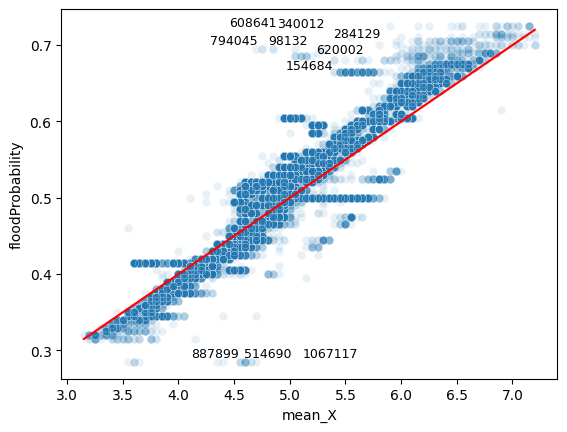

In [3]:
from adjustText import adjust_text

mean_X = train.drop(columns='FloodProbability').mean(axis=1)
prediction_df = pd.DataFrame({
        'mean_X': mean_X,
        'floodProbability': train['FloodProbability'],
        'prediction': mean_X * 0.1
    })
prediction_df['differences'] = abs(prediction_df['prediction'] - prediction_df['floodProbability'])

sns.scatterplot(data=prediction_df, x='mean_X', y='floodProbability', alpha=0.1)
sns.lineplot(data=prediction_df, x='mean_X', y= 'prediction', color='red')

top_differences = prediction_df.nlargest(10, 'differences')
texts = []
for idx, row in top_differences.iterrows():
    text = plt.text(row['mean_X'], row['floodProbability'], f"{idx}", fontsize=9, color='black')
    texts.append(text)
adjust_text(texts)

plt.show()

In [6]:
train.iloc[prediction_df.nlargest(10, 'differences').index].apply(lambda row : row[:-1].std(), axis=1) # std of each
train.iloc[prediction_df.nlargest(10, 'differences').index]

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
794045,5,5,4,7,3,4,3,2,6,5,...,5,5,5,2,6,6,5,8,2,0.695
340012,3,3,6,8,5,5,5,3,6,4,...,5,2,5,5,6,4,8,4,5,0.695
608641,10,7,6,5,5,2,4,4,5,10,...,5,2,3,3,4,8,3,4,3,0.695
98132,4,5,5,5,6,3,4,7,4,3,...,0,3,6,0,11,3,8,8,4,0.695
284129,6,5,5,4,4,9,0,7,2,3,...,7,5,5,0,4,9,3,5,6,0.695
620002,8,7,0,5,9,6,4,7,3,8,...,5,3,3,3,7,5,7,0,6,0.695
1067117,2,10,2,6,3,4,4,2,5,5,...,6,3,4,7,2,3,7,8,7,0.285
514690,4,6,13,3,3,3,4,2,2,3,...,10,2,7,6,6,4,5,3,5,0.285
887899,2,8,4,5,4,8,10,8,3,7,...,7,3,2,6,4,4,4,2,2,0.285
154684,5,8,2,5,9,6,3,5,4,6,...,1,6,5,2,9,2,6,5,7,0.685


# 2. Would KNN work? How close are things

- Are all the vals different? Does this mean our test is all dif?

In [7]:
print("Train rows:", len(train))
print("Train unique:", len(train.drop(columns='FloodProbability').drop_duplicates()))

print("Test rows:", len(test))
print("Test unique:", len(test.drop(columns='FloodProbability', errors='ignore').drop_duplicates()))

combined = pd.concat([train, test], axis=0)

print("Combined rows:", len(combined))
print("Combined unique:", len(combined.drop(columns='FloodProbability', errors='ignore').drop_duplicates()))

Train rows: 1117957
Train unique: 1117957
Test rows: 745305
Test unique: 745305
Combined rows: 1863262
Combined unique: 1863262


In [8]:
X_train, X_test, y_train, y_test = \
    train_test_split(train.drop(columns='FloodProbability'), train['FloodProbability'], test_size=0.1, random_state=42)

knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=1)

In [9]:
# Parameters
batch_size = 100  # Adjust based on your data and system capabilities
n_batches = len(X_test) // batch_size + (1 if len(X_test) % batch_size != 0 else 0)

# Initialize variables to store cumulative predictions and true values
y_pred_cumulative = []
y_true_cumulative = []

# Predict in batches and print R^2 scores along the way
for i in range(n_batches):
    # Get the current batch of test data
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(X_test))
    
    batch_X = X_test[start_idx:end_idx]
    batch_y = y_test[start_idx:end_idx]
    
    # Predict for the current batch
    y_pred_batch = knn.predict(batch_X)
    
    # Append the predictions and true values to the cumulative lists
    y_pred_cumulative.extend(y_pred_batch)
    y_true_cumulative.extend(batch_y)
    
    # Compute the R^2 score for this batch
    r2 = r2_score(y_true_cumulative, y_pred_cumulative)
    
    # Print the R^2 score at this point
    print(f"Batch {i + 1}/{n_batches} - R^2 score: {r2:.4f}")

# Final R^2 score after all batches
final_r2 = r2_score(y_true_cumulative, y_pred_cumulative)
print(f"Final R^2 score: {final_r2:.4f}")


Batch 1/1118 - R^2 score: 0.5430
Batch 2/1118 - R^2 score: 0.2860
Batch 3/1118 - R^2 score: 0.2755
Batch 4/1118 - R^2 score: 0.2841
Batch 5/1118 - R^2 score: 0.3218
Batch 6/1118 - R^2 score: 0.3190
Batch 7/1118 - R^2 score: 0.3352
Batch 8/1118 - R^2 score: 0.3176
Batch 9/1118 - R^2 score: 0.3340
Batch 10/1118 - R^2 score: 0.3604


KeyboardInterrupt: 

So, 1NN dogshit

But what about KNN, and then adjusting own prediction based on dist. to neighbors vals?

In [12]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

# Fit the KNN model
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train, y_train)


# Prediction function with adjustment
def predict_with_adjustment(knn, X_test, y_test, adjustment_factor=0.1):
    y_pred_cumulative = []
    y_true_cumulative = []
    differences = []

    for i in range(len(X_test)):
        test_row = X_test[i:i+1]  # Current row for prediction
        true_value = y_test.iloc[i]
        # print(test_row, true_value)

        # Get the prediction using KNN
        y_pred = knn.predict(test_row)[0]
        # print("y prediction:", y_pred)

        # Find the k-nearest neighbors (for 1-NN, it is just the closest neighbor)
        neighbors = knn.kneighbors(test_row, return_distance=False)
        # print("neighbors", neighbors)

        # Get the feature values of the nearest neighbor (cluster center for 1-NN)
        neighbor_center = X_train.iloc[neighbors[0]].mean(axis=0).mean()
        # print("neighbor center", neighbor_center)

        # Calculate the average of the test row
        test_row_avg = test_row.mean(axis=1).values
        # print("test row avg", test_row_avg)

        # Compute the difference between the averages
        difference = test_row_avg - neighbor_center
        # print("diff", difference)

        # Adjust the prediction by adding 0.1 * the difference
        adjusted_pred = y_pred + adjustment_factor * np.sum(difference)

        # print("initial pred:", y_pred)
        # print("adjusted pred:", adjusted_pred)
        # print("actual value:", true_value)

        # Store predictions and true values for later R^2 calculation
        y_pred_cumulative.append(adjusted_pred)
        y_true_cumulative.append(true_value)
        differences.append(difference)


        # Print R^2 score after each batch (optional)
        r2 = r2_score(y_true_cumulative, y_pred_cumulative)
        print(f"R^2 score: {r2:.4f}")
        print(f"Difference mean: {np.mean(np.abs(differences))}, std: {np.std(np.abs(differences))}")

    # Final R^2 score
    final_r2 = r2_score(y_true_cumulative, y_pred_cumulative)
    print(f"Final R^2 score: {final_r2:.4f}")

    return np.array(y_pred_cumulative)

# Make predictions with adjustment
y_pred_adjusted = predict_with_adjustment(knn, X_test, y_test)


/Users/akhilkammila/miniconda3/envs/tradingClub/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


R^2 score: nan
Difference mean: 0.04999999999999982, std: 0.0
R^2 score: -4.0617
Difference mean: 0.1499999999999999, std: 0.10000000000000009
R^2 score: 0.7110
Difference mean: 0.10555555555555578, std: 0.10304020550550762
R^2 score: 0.6864
Difference mean: 0.09583333333333344, std: 0.09081039465709723
R^2 score: 0.7800
Difference mean: 0.10000000000000017, std: 0.0816496580927725
R^2 score: 0.8786
Difference mean: 0.15000000000000022, std: 0.13437096247164249
R^2 score: 0.9158
Difference mean: 0.13095238095238113, std: 0.13286482312670198
R^2 score: 0.8877
Difference mean: 0.11875000000000013, std: 0.12840839255195818
R^2 score: 0.9420
Difference mean: 0.10740740740740752, std: 0.12524324754748833
R^2 score: 0.9473
Difference mean: 0.09833333333333352, std: 0.12189476335484367
R^2 score: 0.9432
Difference mean: 0.09848484848484862, std: 0.11622308430766731
R^2 score: 0.9432
Difference mean: 0.09583333333333344, std: 0.11162208894632257
R^2 score: 0.9201
Difference mean: 0.09615384615

KeyboardInterrupt: 

In [26]:
num_calculated = len(y_true_cumulative)

knn_df = X_test.iloc[:num_calculated].copy()
knn_df['mean'] = knn_df.mean(axis=1)
knn_df['meanPrediction'] = knn_df['mean'] * 0.1
knn_df['floodProbability'] = y_true_cumulative
knn_df['knnPrediction'] = y_pred_cumulative
knn_df.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,mean,meanPrediction,floodProbability,knnPrediction
1105809,7,5,8,4,8,4,8,4,3,7,...,7,2,3,6,7,2,5.20,0.520,0.560,0.540
442591,5,3,10,9,9,6,4,2,4,9,...,7,6,4,2,9,6,5.65,0.565,0.575,0.575
5434,5,6,2,6,3,4,4,4,4,1,...,5,6,7,7,6,5,5.10,0.510,0.510,0.485
82966,7,3,6,4,4,5,8,5,6,5,...,8,7,4,6,5,4,5.25,0.525,0.530,0.580
584893,6,5,7,7,5,5,5,6,3,7,...,9,5,6,4,5,8,5.60,0.560,0.590,0.535


<Axes: xlabel='mean', ylabel='floodProbability'>

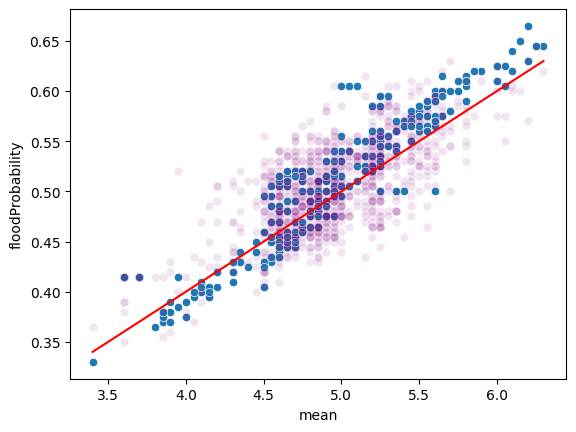

In [35]:
sns.scatterplot(data=knn_df, x='mean', y='floodProbability')
sns.lineplot(data=knn_df, x='mean', y='meanPrediction', color='red')
sns.scatterplot(data=knn_df, x='mean', y='knnPrediction', color='purple', alpha=0.1)
